# Requirements 

In [1]:
import torch
import diffusers
print(f"Diffusers version: {diffusers.__version__}")
print(f"PyTorch version: {torch.__version__}")

Diffusers version: 0.32.1
PyTorch version: 2.5.1


# Process single image

In [2]:
from diffusers import AutoencoderDC
import torch

device="mps" # change to 'cuda' for NVIDIA GPUs

# Load the DC-AE f32c32-sana in 16bit precision
ae=AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers", torch_dtype=torch.float16).to(device).eval()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [3]:
ae.encoder

Encoder(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): ResBlock(
        (nonlinearity): SiLU()
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): RMSNorm()
      )
      (1): ResBlock(
        (nonlinearity): SiLU()
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): RMSNorm()
      )
      (2): DCDownBlock2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (1): Sequential(
      (0): ResBlock(
        (nonlinearity): SiLU()
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 256, kernel_siz

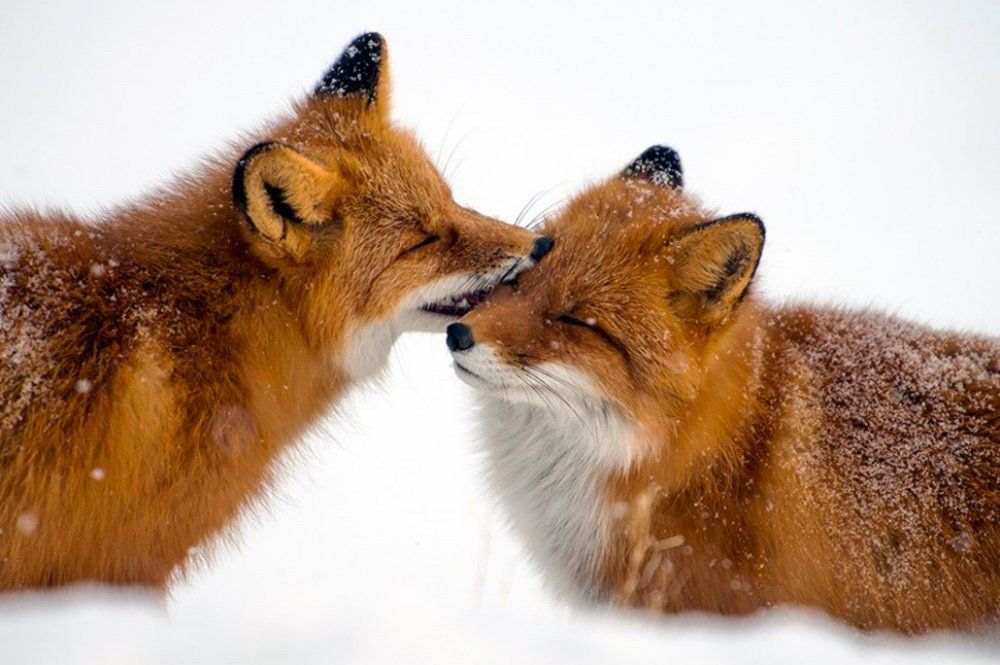

In [4]:
from PIL import Image
from io import BytesIO
import requests

URL="https://github.com/geronimi73/3090_shorts/blob/main/assets/3.jpg?raw=True"

image = Image.open(BytesIO(requests.get(URL).content))

import torchvision.transforms as T
image.size, T.ToTensor()(image).flatten().shape
image

In [5]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(512, antialias=True),
    # This will center crop to 512x512 from the resized image
    T.CenterCrop(512),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    lambda x: x.to(dtype=torch.float16)
])

image_tensor = transform(image)[None].to(device)
T.ToTensor()(T.Resize(512, antialias=True)(image)).shape,image_tensor.shape,image_tensor.flatten().shape

(torch.Size([3, 512, 769]), torch.Size([1, 3, 512, 512]), torch.Size([786432]))

In [6]:
%%time
with torch.no_grad():
    latent = ae.encode(image_tensor)
latent.latent.shape,latent.latent.flatten().shape, latent.latent.min(), latent.latent.max()

CPU times: user 577 ms, sys: 146 ms, total: 724 ms
Wall time: 505 ms


(torch.Size([1, 32, 16, 16]),
 torch.Size([8192]),
 tensor(-17.4375, device='mps:0', dtype=torch.float16),
 tensor(7.5078, device='mps:0', dtype=torch.float16))

In [7]:
786432/8192

96.0

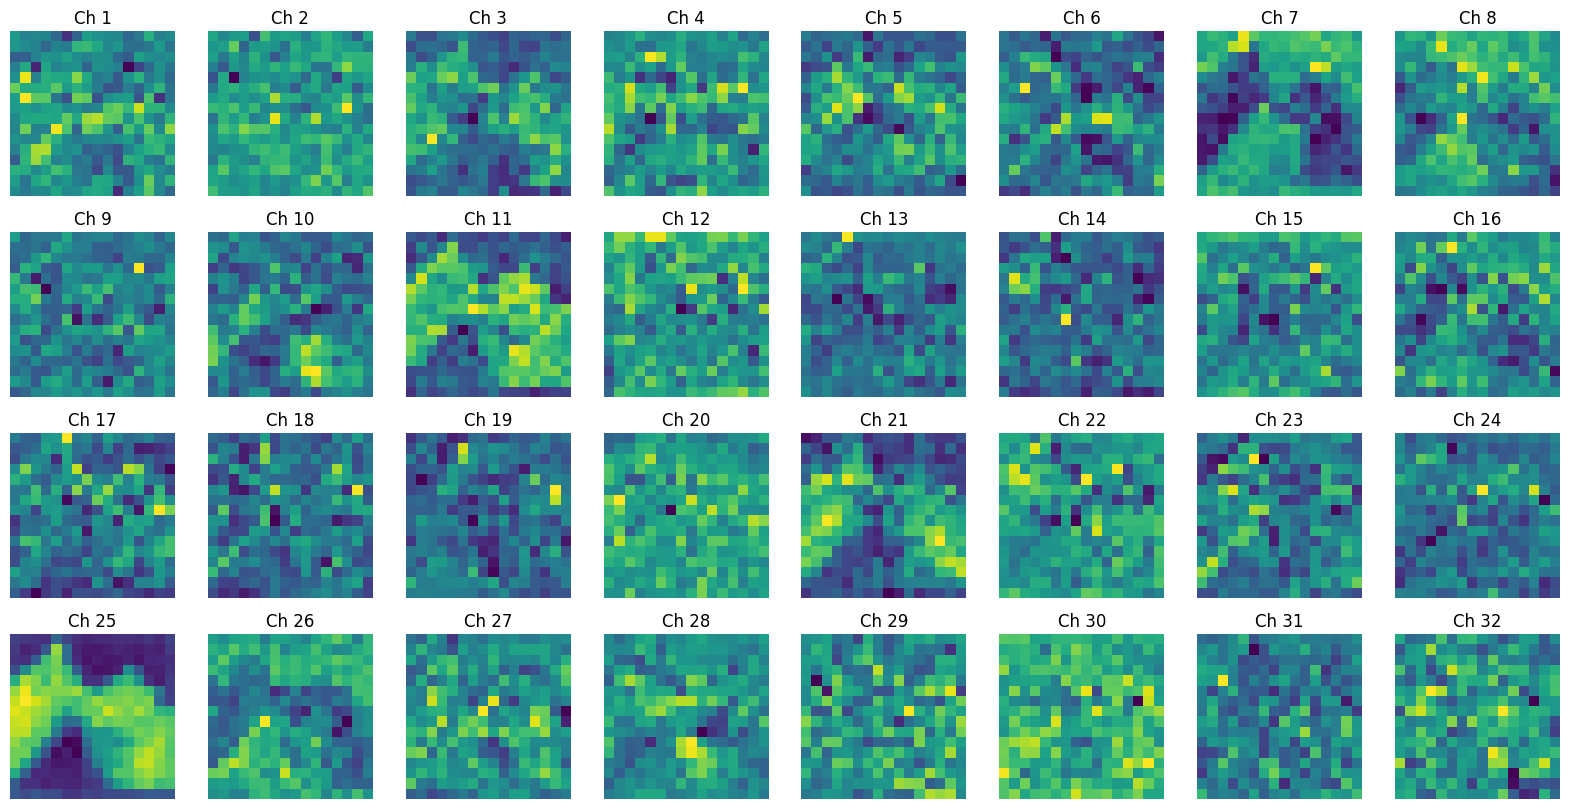

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    channel = latent.latent[0, i].detach().cpu()
    channel_min, channel_max = channel.min(), channel.max()
    channel_normalized = (channel - channel_min) / (channel_max - channel_min)
    
    ax.imshow(channel_normalized, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Ch {i+1}')

In [9]:
from torchvision.utils import save_image

with torch.no_grad():
    image_out = ae.decode(latent.latent).sample

image_out = torch.clamp_(image_out, -1, 1)    # clamp, because output of is AE sometimes out of [-1;1] for some reason
save_image(image_out * 0.5 + 0.5, "demo_dc_ae.png") # normalize to 0-1

image_out.shape, image_out.min(),image_out.max()

(torch.Size([1, 3, 512, 512]),
 tensor(-1., device='mps:0', dtype=torch.float16),
 tensor(1., device='mps:0', dtype=torch.float16))

In [10]:
image_out = image_out.squeeze() * 0.5 + 0.5   # normalize to 0-1
image_out.shape, image_out.min(),image_out.max()

(torch.Size([3, 512, 512]),
 tensor(0., device='mps:0', dtype=torch.float16),
 tensor(1., device='mps:0', dtype=torch.float16))

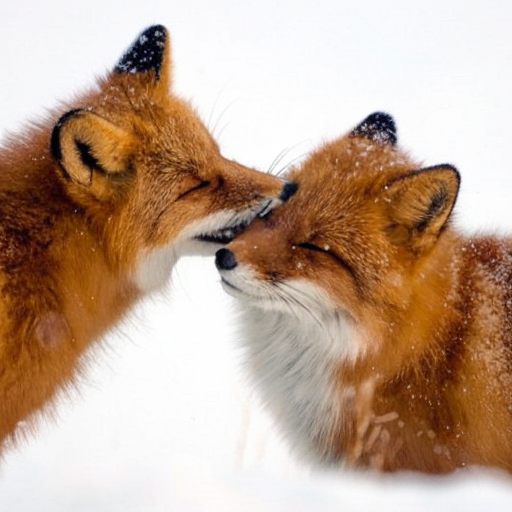

In [11]:
T.ToPILImage()(image_out)

# Process entire directory

In [12]:
import torchvision.transforms as T
import torch
import os
import gc
from PIL import Image, ImageDraw, ImageFont

def to_latent_and_back(filename, dc_ae, device="mps"):
    transform = T.Compose([
        T.Resize(512, antialias=True),
        # This will center crop to 512x512 from the resized image
        T.CenterCrop(512),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(dtype=torch.float16)
    ])
    image = Image.open(filename)
    image = transform(image)[None].to(device)
    print("\tTransformed input image",image.shape,image.flatten().shape,f"(values {image.min():.3f} to {image.max():.3f})")
    
    # Encode and decode
    with torch.no_grad():
        latent = dc_ae.encode(image)
    print("\tLatent",latent.latent.shape,latent.latent.flatten().shape,f"(values {latent.latent.min():.3f} to {latent.latent.max():.3f})")
    with torch.no_grad():
        image_out = dc_ae.decode(latent.latent)
    image_out.sample = torch.clamp(image_out.sample, -1.0, 1.0)    # clamp because output of is AE sometimes >1 or <-1 for some reason
    print("\tClamped output image",image_out.sample.shape,f"(values {image_out.sample.min():.3f} to {image_out.sample.max():.3f})")
        
    return [image * 0.5 + 0.5, image_out.sample * 0.5 + 0.5]

def concatenate_images(image_paths, output_path):
    images = [Image.open(image_path) for image_path in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    new_image.save(output_path)


def add_label(image_tensor, label, relative_font_size=0.07):
    if isinstance(image_tensor, torch.Tensor):
        if image_tensor.dim() == 4: image_tensor = image_tensor.squeeze(0)
        image_pil = T.ToPILImage()(image_tensor)
    else: image_pil = image_tensor
    
    font_size = int(image_pil.height * relative_font_size)
    draw = ImageDraw.Draw(image_pil)
    
    try: font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", font_size)
    except: font = ImageFont.load_default()
    
    # Add text at the bottom of the image
    text_width = draw.textlength(label, font=font)
    x = (image_pil.width - text_width) / 2  # Center text horizontally
    # y = image_pil.height - font_size * 1.5  # Place near bottom
    y = 0 #font_size * 1.5  # Place near bottom
    
    # Draw text with a dark background for better visibility
    padding = font_size // 4
    draw.rectangle([x - padding, y - padding, x + text_width + padding, y + font_size + padding], fill='black')
    draw.text((x, y), label, fill='white', font=font)
    
    return image_pil

def clear_cache(): 
    gc.collect()
    if device=="mps": torch.mps.empty_cache()
    else: torch.cuda.empty_cache()

In [ ]:
from torchvision.utils import save_image
from diffusers import AutoencoderDC
import os

device = "mps"
aes = [
    ("dc-ae-f32c32-sana-1.0", "mit-han-lab/dc-ae-f32c32-sana-1.0-diffusers"),
    ("dc-ae-f32c32-in-1.0", "mit-han-lab/dc-ae-f32c32-in-1.0-diffusers"),
    ("dc-ae-f32c32-mix-1.0", "mit-han-lab/dc-ae-f32c32-mix-1.0-diffusers"),
    ("dc-ae-f64c128-in-1.0", "mit-han-lab/dc-ae-f64c128-in-1.0-diffusers"),
    ("dc-ae-f64c128-mix-1.0", "mit-han-lab/dc-ae-f64c128-mix-1.0-diffusers"),
    ("dc-ae-f128c512-in-1.0", "mit-han-lab/dc-ae-f128c512-in-1.0-diffusers"),
    ("dc-ae-f128c512-mix-1.0", "mit-han-lab/dc-ae-f128c512-mix-1.0-diffusers"),
]

inputs_path, output_path, outputgall_path = "./inputs", "./output", "./output_galleries"
for directory in [output_path, outputgall_path]:
    if not os.path.exists(directory): os.makedirs(directory)

for ae_name, ae_repo in aes:
    ae = AutoencoderDC.from_pretrained(ae_repo, torch_dtype=torch.float16).to(device).eval()

    for image_filename in os.listdir(inputs_path):
        base_path, ext = os.path.splitext(image_filename)
        print(ae_name, image_filename)

        input_transformed, latent_decoded = to_latent_and_back(inputs_path + "/" + image_filename, ae, device)
        # save single imgs
        save_image(input_transformed, f"{output_path}/{base_path}_input{ext}")
        add_label(latent_decoded, ae_name).save(f"{output_path}/{base_path}_roundtrip_{ae_name}_{ext}")  # convert to PIL for adding text
        
    ae=None;clear_cache()

dc-ae-f32c32-sana-1.0 8.jpg
	Transformed input image torch.Size([1, 3, 512, 512]) torch.Size([786432]) (values -1.000 to 1.000)
	Latent torch.Size([1, 32, 16, 16]) torch.Size([8192]) (values -7.617 to 7.602)
	Clamped output image torch.Size([1, 3, 512, 512]) (values -1.000 to 1.000)
dc-ae-f32c32-sana-1.0 9.jpg
	Transformed input image torch.Size([1, 3, 512, 512]) torch.Size([786432]) (values -1.000 to 1.000)
	Latent torch.Size([1, 32, 16, 16]) torch.Size([8192]) (values -8.617 to 9.133)
	Clamped output image torch.Size([1, 3, 512, 512]) (values -1.000 to 1.000)
dc-ae-f32c32-sana-1.0 4.jpg
	Transformed input image torch.Size([1, 3, 512, 512]) torch.Size([786432]) (values -0.647 to 1.000)
	Latent torch.Size([1, 32, 16, 16]) torch.Size([8192]) (values -20.188 to 8.672)
	Clamped output image torch.Size([1, 3, 512, 512]) (values -0.716 to 1.000)
dc-ae-f32c32-sana-1.0 5.jpg
	Transformed input image torch.Size([1, 3, 512, 512]) torch.Size([786432]) (values -1.000 to 0.828)
	Latent torch.Size(

In [ ]:
# Create galleries
for image_filename in os.listdir(inputs_path):
    base_path, ext = os.path.splitext(image_filename)
    images = [f"{output_path}/{base_path}_input{ext}"] + [f"{output_path}/{base_path}_roundtrip_{ae_name}_{ext}" for ae_name, _ in aes if not "-mix-" in ae_name]
    concatenate_images(images, f"{outputgall_path}/{base_path}_gallery{ext}")